<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Stopped_Muons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral -q
 
import numpy as np
import tensorflow as tf
import keras
import pickle
import spektral
 
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.sparse import SparseTensor
 
from keras import backend as K
 
from time import time
 
 
from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import AGNNConv, GlobalSumPool, GlobalMaxPool, GlobalAvgPool, GCNConv, ECCConv
from spektral import transforms
 
from tqdm.notebook import tqdm
 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
 
PI = np.pi
 
 
# Lifehack
true = True
false = False

In [ ]:
!pip install wandb -q

import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataStoppedMuon100000events 0.npz" # Cleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      # e,a,z = g["y"]
      # g["y"] = [transformer['energy_log10'].inverse_transform([[e]])[0][0],transformer['azimuth'].inverse_transform([[a]])[0][0]-PI,transformer['zenith'].inverse_transform([[z]])[0][0]]
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])

Dataset is dat(n_graphs=100000) consisting of Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=1)


In [ ]:

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs


def lr_schedule(start_lr,epoch,total_epochs):
  # return start_lr/((1+epoch/total_epochs)*5)
  if epoch < total_epochs//4:
    return start_lr*(1+epoch/(total_epochs//4))
  return 2*start_lr/(10*epoch/total_epochs)

In [ ]:
################################################################################
# PARAMETERS
################################################################################
#@markdown ### Define the model and training parameters and sync with WandB
batch_size =  32#@param {type: "number"}
 
# one-variable network size changer
network_size =  128#@param {type: "number"}
 
learning_rate =   1e-3#@param {type: "number"}
 
training_epochs = 30 #@param {type: "slider", min: 10, max: 200}
 
early_stopping_rounds =  3#@param {type: "number"}
 
dropout_rate = 0.1 #@param {type: "number"}
 
loss_function = "binary_cross_entropy"  #@param ['custom_loss',"rasmus_loss","binary_cross_entropy"]
 
config = {
        "learning_rate": learning_rate,
        "epochs": training_epochs,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "architecture": "Broadening CNN - short but wide",
        "network_size": network_size,
        "dropout_rate": dropout_rate,
        "dataset": "MuonGun",
        "early_stopping_rounds": early_stopping_rounds,
      }
 
epochs = config["epochs"]  # Number of training epochs
test_epochs = 2 # Number of testing epochs

In [ ]:
# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, shuffle=True)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)





class model_class(Model):
  def __init__(self):
    super().__init__()
    
    self.preprocess = transforms.layer_preprocess.LayerPreprocess(GCNConv)

    # self.inp = ECCConv(network_size//4)

    self.steps = [2**i for i in range(2)]
    self.convs = [GCNConv(network_size*s,activation="gelu") for s in self.steps]

    self.maxpool = GlobalMaxPool()
    self.avgpool = GlobalAvgPool()
    self.sumpool = GlobalSumPool()

    self.denses = [Dense(network_size*s,activation= "gelu") for s in self.steps[::-1]]
    self.dropouts = [Dropout(dropout_rate) for s in self.steps]
    # self.normalizations = [BatchNormalization() for s in self.steps]

    self.out = Dense(n_out,activation = "sigmoid")
    # self.oneout = Dense(1)

  def call(self, inputs, training = False):

    x, a, i = inputs
    # a, e    = self.generate_edge_features(x, a) # NEXT STEP is implementing this for myself
    # x = self.inp([x,a,e])
    # a = self.preprocess(a)
    for conv in self.convs:
      x = conv([x,a])
    
    
    xm = self.maxpool([x,i])
    xa = self.avgpool([x,i])
    xs = self.sumpool([x,i])

    x = tf.concat([xm, xa, xs], axis = 1) 


    for dense, dropout in zip(self.denses,self.dropouts):
      # x = norm(x) # ,training = training # batch_normalization is broken in curretn keras
      x = dense(x)
      x = dropout(x,training = training)


    out = self.out(x)

    # xe = self.smalldense(x)
    # xa = self.smalldense(x)
    # xz = self.smalldense(x)

    # oute = self.oneout(xe)
    # outa1 = self.oneout(xa)
    # outa2 = self.oneout(xa)

    # outz1 = self.oneout(xz)
    # outz2 = self.oneout(xz)


    return out
    # return tf.concat([oute, outa1,outa2, outz1,outz2], axis = 1) 


  #Shamelessly stolen from Johann
  def generate_edge_features(self, x, a):
      send    = a.indices[:, 0]
      receive = a.indices[:, 1]

      diff_x  = tf.subtract(tf.gather(x, receive), tf.gather(x, send))

      dists   = tf.sqrt(
        tf.reduce_sum(
          tf.square(
            diff_x[:, :3]
          ), axis = 1
        ))

      vects = tf.math.divide_no_nan(diff_x[:, :3], tf.expand_dims(dists, axis = -1))

      e = tf.concat([diff_x[:, 3:], tf.expand_dims(dists, -1), vects], axis = 1)

      return a, e

# Build model
model = model_class()

opt = Adam(lr=learning_rate,clipvalue=1)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC

loss_fn = BinaryCrossentropy()
acc_fn =  AUC()
# loss_fn = custom_loss
# loss_fn = MeanAbsoluteError()
# acc_fn = custom_acc


model.compile()
# model.build()
# fit(train_loader)

In [ ]:
################################################################################
# DEFINE TF-FUNCTIONS
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc


def fit(train_loader,logwandb = False):
  if logwandb:
    run = wandb.init(project='IceCube Stopped Muons',config = config)

  current_batch = 0
  model_loss = []
  model_acc = []
  vali_loss = []
  epoch = 0

  earlystop = 0
  should_stop = False

  epoch_steps = train_loader.steps_per_epoch

  t = tqdm(total  = train_loader.steps_per_epoch,leave = True, ncols='70%')
  t.set_description(f'Currently on epoch {0} of {epochs} ')

  pb = []
  tar = []
  step = 0

  last_loss = 0
  
  for batch in train_loader:
      if should_stop:
        print("Ending fitting because of early stopping")
        break

      step += 1
      inputs, target = batch
      inputs = scale_inputs(inputs)

      loss, acc = train_step(inputs,target)

      model_loss.append(loss)
      model_acc.append(acc)
      current_batch += 1
      t.update(1)

      if step%100 == 0:
        t.set_description(f'Current loss {np.mean(model_loss):.3} | Working on epoch {epoch} of {epochs}:')

      if current_batch == epoch_steps:
          test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
          t.set_description(f'Currently validating results for epoch {epoch} of {epochs}:')
          vali_acc = []
          for vali_batch in test_loader:
            vali_inputs, vali_target = vali_batch
            valie_inputs = scale_inputs(vali_inputs)
            valoss, vaacc = validate(vali_inputs,vali_target)
            vali_acc.append(vaacc)
            vali_loss.append(valoss)
          va = np.mean(vali_loss)
          vaac = np.mean(vali_acc)

          m_loss = np.mean(model_loss)
          change = (m_loss-last_loss)/max(0.000001,last_loss)
          last_loss = m_loss

          s = "Train loss: {} - Loss change {:+.3f}% | Validation loss {} | Epoch: {}".format(m_loss, change*100,va, epoch)
          t.write(s)
          ma = np.array(model_acc)
          s = "Train accuracy: {:.3} | Validation accuracy: {:.3}".format(np.mean(ma),vaac)
          t.write(s)

          if m_loss < va:
            if earlystop < early_stopping_rounds:
              earlystop += 1
            else:
              should_stop = True
          else:
            earlystop = 0



          if epoch%10 == 0:
            # maybe write a saving state here
            pass

          # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])

          # if epoch%5 == 0 and epoch != 0:
            # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])
            # pass
          # else:
            # pb = model(inputs, training=False)
            # tar = target



          if logwandb:
            wandb.log({
                      "train_loss": m_loss,
                      "train_accuracy": np.mean(ma),
                      "validation_loss": va,
                      "validation_accuracy": vaac,
                      })




          model_loss = []
          model_acc = []
          vali_loss = []
          current_batch = 0
          step = 0

          t.n = 0
          t.last_print_n = 0
          t.refresh()

          epoch += 1


          K.set_value(model.optimizer.learning_rate, lr_schedule(learning_rate,epoch,epochs))

In [ ]:
logwandb = True

fit(train_loader,logwandb = logwandb)

print("\n\nTraining of the following model is now complete:")
model.summary()
save_path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models"


if logwandb:
  pth = save_path + f"/{wandb.run.name}-run"
  wandb.run.finish()  
else:
  pth = save_path + "/StoppedMuons  "

model.save(pth)

train_loss,0.47406
train_accuracy,0.75611
validation_loss,0.46754
validation_accuracy,0.75703
_runtime,1440
_timestamp,1615461811
_step,11


train_loss,█▅▄▃▃▃▂▂▂▁▁▁
train_accuracy,▁▃▄▅▆▆▆▇▇▇██
validation_loss,█▇▅▅▄▄▅▄▂▂▂▁
validation_accuracy,▁▃▄▄▅▆▆▇▇▇██
_runtime,▁▂▂▃▄▄▅▅▆▇▇█
_timestamp,▁▂▂▃▄▄▅▅▆▇▇█
_step,▁▂▂▃▄▄▅▅▆▇▇█


Train loss: 0.5647515058517456 - Loss change +56475150.585% | Validation loss 0.5127106308937073 | Epoch: 0
Train accuracy: 0.707 | Validation accuracy: 0.749
Train loss: 0.5166946649551392 - Loss change -8.509% | Validation loss 0.49791085720062256 | Epoch: 1
Train accuracy: 0.759 | Validation accuracy: 0.766
Train loss: 0.5034651756286621 - Loss change -2.560% | Validation loss 0.48450028896331787 | Epoch: 2
Train accuracy: 0.771 | Validation accuracy: 0.776
Train loss: 0.4913567006587982 - Loss change -2.405% | Validation loss 0.4822896122932434 | Epoch: 3
Train accuracy: 0.78 | Validation accuracy: 0.783
Train loss: 0.48472872376441956 - Loss change -1.349% | Validation loss 0.47630128264427185 | Epoch: 4
Train accuracy: 0.786 | Validation accuracy: 0.789
Train loss: 0.47988712787628174 - Loss change -0.999% | Validation loss 0.47083139419555664 | Epoch: 5
Train accuracy: 0.791 | Validation accuracy: 0.793
Train loss: 0.4784904420375824 - Loss change -0.291% | Validation loss 0.470

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)


def make_1D(lst):
  return [val for sublist in lst for val in sublist]

@tf.function(input_signature=test_loader.tf_signature(), experimental_relax_shapes=True)
def get_predictions(inputs,target):
  pred = model(inputs,training = False)

  return pred

def test_model():
  truths, guesses = [], []
  for batch in tqdm(test_loader):
    inputs, target = batch
    inputs = scale_inputs(inputs)
    preds = get_predictions(inputs, target)
    truths.append(batch[1])
    guesses.append(preds)
  return np.array(make_1D(guesses)).squeeze(),np.array(make_1D(truths)).squeeze()

def plot_roc(y_true,y_score):
  rc = roc_curve(y_true, y_score)
  fpr, tpr, th = rc
  auc = roc_auc_score(y_true, y_score)

  plt.figure(figsize = (10,10))
  plt.plot(fpr,tpr)
  plt.title("ROC-curve with auc {:.3}".format(auc))
  plt.show()


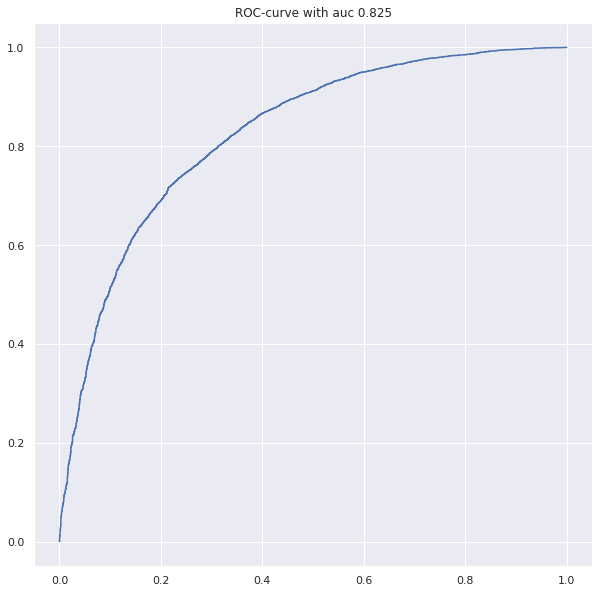

In [ ]:
preds, truths = test_model()
plot_roc(truths,preds)

(20000,)